In [1]:
!pip install transformers datasets


In [2]:
import torch
torch.cuda.is_available()#, torch.cuda.get_device_name(0)

True

In [2]:
from datasets import Dataset,load_dataset

In [3]:
ds = load_dataset(
    "csv",
    data_files={"train":"train_en.tsv",
                "dev": "dev_test_en.tsv",
                "test": "test_en_labeled.tsv"
    },
    delimiter="\t"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
def encode_label(example):
    example["label"] = 0 if example["label"] == "OBJ" else 1
    return example

ds = ds.map(encode_label)
ds = ds.rename_column("label", "labels")
ds = ds.remove_columns("sentence_id")
ds = ds.remove_columns("solved_conflict")


Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [5]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [6]:
show_random_elements(ds["train"])

,sentence,labels
0,"The former president has faced many legal struggles, including his Mar-a-Lago property being searched by the FBI and his involvement in the Jan. 6 insurrection being investigated by a House select committee.",0
1,"First by habit one thinks of those for which we have traditional images: The machine, the boss, the pork barrel, the spoils system, the politician everywhere in his popular character, acquiring merit and power by spending public money; doing things for his people with the money of other people, taking care at the same time to do enough for himself with everybody’s money.",1
2,"Consider, for example, what Olga Skabeyeva, one of the most energetically toxic, said on the government's Rossiya-1 channel.",1
3,"A portion of positive tests around the country is being forwarded to the agency for genetic sequencing, according to a report by CBS News.",0
4,"""I had to think about what it would be like,"" he said.",0
5,"During the ‘Striketober’ of late 2021, rank and file workers at companies like Kellogg’s and John Deere voted down substandard agreements and won better contracts in the end by doing so.",0
6,"Therefore, it knew what could happen to the public credit of a city.",0
7,"Of course, illegal aliens by definition are guilty of unlawful conduct and it is hard to imagine them going about their daily business without committing acts involving dishonesty, fraud, deceit, or misrepresentation.",1
8,Why are teachers unhappy?,0
9,"The accused Somalis donated to a variety of politicians, including Rep. Ilhan Omar, State Senator Omar Fateh, Shukri Olow, running for state representative, State Rep. Hodan Hassan, a Keith Ellison crony, and others.",0


In [5]:
model_checkpoint = 'distilbert/distilbert-base-uncased'
tokenizer_checkpoint = 'distilbert/distilbert-base-uncased'

In [6]:
from transformers import (
    AutoTokenizer,
    DistilBertTokenizer
)

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_checkpoint,truncation=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["sentence"],
        truncation=True,)

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [10]:
# Then tokenize the 'sentence' column and remove it, keeping 'label' and the new tokenized columns.
tokenized_datasets = ds.map(tokenize_function, batched=True, num_proc=4, remove_columns=["sentence"])

Map (num_proc=4):   0%|          | 0/830 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/484 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/300 [00:00<?, ? examples/s]

In [11]:
# caso nao precise agrupar
lm_datasets = tokenized_datasets

Funcao de perda utilizando Cross-Entropy

In [12]:
from collections import Counter
import torch

label_counts = Counter(tokenized_datasets["train"]["labels"])
num_classes = len(label_counts)

# Example: dataset with labels 0 and 1
counts = [label_counts[i] for i in range(num_classes)]
total = sum(counts)

# Inverse frequency weighting
class_weights = [total / c for c in counts]

print("Class weights:", class_weights)

# Convert to tensor (move to CUDA later)
class_weights = torch.tensor(class_weights)


Class weights: [1.5601503759398496, 2.785234899328859]


In [13]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss
from transformers import DistilBertForSequenceClassification
from typing import Optional, Union
from transformers.modeling_outputs import SequenceClassifierOutput


class WeightedDistilBertForSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config, class_weights=None):
        super().__init__(config)

        # Store weights (tensor or None)
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float)
        else:
            self.class_weights = None


    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[SequenceClassifierOutput, tuple]:

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_state = distilbert_output[0]              # (batch_size, seq_len, dim)
        pooled_output = hidden_state[:, 0]              # (batch_size, dim)
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:

            # Detect problem type (same logic as original)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif labels.dtype in (torch.long, torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            # Regression
            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)

            # Single-label classification (this is the one we modify)
            elif self.config.problem_type == "single_label_classification":
                if self.class_weights is not None:
                    # Move class weights to the same device
                    class_weights = self.class_weights.to(logits.device)
                    loss_fct = CrossEntropyLoss(weight=class_weights)
                else:
                    loss_fct = CrossEntropyLoss()

                loss = loss_fct(
                    logits.view(-1, self.num_labels),
                    labels.view(-1)
                )

            # Multi-label classification - unchanged
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

In [ ]:
import torch
from torch import nn
from transformers import DistilBertForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput

class WeightedDistilBert(DistilBertForSequenceClassification):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.class_weights = class_weights

    def forward(self, *args, **kwargs):
        labels = kwargs.get("labels", None)

        # Remove labels so DistilBERT does NOT compute its own loss
        model_kwargs = {k: v for k, v in kwargs.items() if k != "labels"}

        # Call the original DistilBERT forward
        outputs = super().forward(*args, **model_kwargs)

        logits = outputs.logits
        loss = None

        if labels is not None:
            labels = labels.to(logits.device)
            loss_fct = nn.CrossEntropyLoss(
                weight=self.class_weights.to(logits.device)
                if self.class_weights is not None
                else None
            )
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss = loss,
            logits = logits,
            hidden_states = outputs.hidden_states,
            attentions = outputs.attentions,
        )


Vamos criar as variáveis a partir do checkpoint do modelo

In [14]:
from transformers import (
    AutoConfig,
    DistilBertConfig,
    DistilBertForSequenceClassification
)

In [15]:


num_labels = len(set(lm_datasets["train"]["labels"]))

# config = DistilBertConfig.from_pretrained(model_checkpoint,
#                                     num_labels=num_labels,
#                                     class_weights=class_weights,
#                                     hidden_dropout_prob=0.1,
#                                     attention_probs_dropout_prob=0.1,
#                                     id2label={i: str(i) for i in range(num_labels)},
#                                     label2id={str(i): i for i in range(num_labels)}
#                                     )
#
model = WeightedDistilBertForSequenceClassification.from_pretrained(model_checkpoint,
    num_labels=num_labels,
    id2label={i: str(i) for i in range(num_labels)},
    label2id={str(i): i for i in range(num_labels)},
    class_weights=class_weights,   # ← vetor de pesos por classe
    # gamma=2.0
    )


# carregamento do checkpoint
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/tmp/ipython-input-2752834623.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float)
Some weights of WeightedDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Definindo hiperparâmetros do treinamento

In [16]:
from transformers import Trainer, TrainingArguments

In [17]:
training_args = TrainingArguments(
    resume_from_checkpoint=False,
    output_dir="./checkpoint/",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    learning_rate=2e-5,
    num_train_epochs=2,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    # fp16=True,
    # optim="adam",
    # gradient_accumulation_steps=1,
    load_best_model_at_end=True,
    report_to="none",
    # ,
    # logging_dir="./logs/",
    logging_steps=10,
    logging_strategy="steps",
    # seed=42,
    remove_unused_columns=True,
)

Classe de treino

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["dev"],
    data_collator=data_collator,

)

And we can train our model:

In [19]:
import time
start = time.time()
trainer.train()
print (time.time() - start)

Epoch,Training Loss,Validation Loss
1,0.535400,0.534028
2,0.309500,0.525923


32.83470630645752


In [ ]:
print(model.state_dict()['distilbert.transformer.layer.0.attention.q_lin.weight'][0][:5])

pred = trainer.predict(tokenized_datasets["test"])
print(pred.predictions.shape)
print(pred.label_ids is not None)



tensor([-0.0025,  0.0222, -0.0210,  0.0312, -0.0100], device='cuda:0')


AttributeError: 'tuple' object has no attribute 'shape'

Analisando resultados

In [24]:
from sklearn.metrics import classification_report

pred = trainer.predict(tokenized_datasets["test"])

logits = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions

y_pred = logits.argmax(axis=-1)

y_true = pred.label_ids

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.80      0.82       215
           1       0.54      0.59      0.56        85

    accuracy                           0.74       300
   macro avg       0.68      0.69      0.69       300
weighted avg       0.75      0.74      0.74       300



In [69]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import os

save_path = "/content/drive/MyDrive/Mestrado/Trabalho_LLM/Checkpoints_Distilbert"
os.makedirs(save_path, exist_ok=True)


In [27]:
import shutil
import os

src = "/content/checkpoint/"
dst = "/content/drive/MyDrive/Mestrado/Trabalho_LLM/Checkpoints_Distilbert"

# create parent directory if needed
os.makedirs(os.path.dirname(dst), exist_ok=True)

# copy the entire folder
shutil.copytree(src, dst, dirs_exist_ok=True)

print("Checkpoint copied successfully!")


Checkpoint copied successfully!


STOP

In [20]:
!pip install transformers datasets gdown evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1CAbb3DjrOPBNm0ozVBfhvrEh9P9rAppc

Retrieving folder contents
Processing file 1e_G-9a66AryHxBOwGWhriePYCCa4_29e subtaskA_dev_monolingual.jsonl
Processing file 123UQ92LxtHaVTbNYlmjnG1CWwD-x7wDL subtaskA_dev_multilingual.jsonl
Processing file 1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI6OG subtaskA_train_monolingual.jsonl
Processing file 13-9-DakCeLFbPgCiVIU0v6_BCQx0ppz6 subtaskA_train_multilingual.jsonl
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1e_G-9a66AryHxBOwGWhriePYCCa4_29e
To: /content/SubtaskA/subtaskA_dev_monolingual.jsonl
100% 10.8M/10.8M [00:00<00:00, 51.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=123UQ92LxtHaVTbNYlmjnG1CWwD-x7wDL
To: /content/SubtaskA/subtaskA_dev_multilingual.jsonl
100% 21.2M/21.2M [00:00<00:00, 69.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI6OG
From (redirected): https://drive.google.com/uc?id=1HeCgnLuDoUHhP-2OsTSSC3FXRLVoI

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os

save_path = "/content/drive/MyDrive/Mestrado/LLM/Checkpoints_Deberta"
os.makedirs(save_path, exist_ok=True)


In [21]:
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging


In [22]:
from peft import LoraConfig, get_peft_model, TaskType

In [26]:
from transformers import DebertaTokenizer

In [23]:
def preprocess_function(examples, **fn_kwargs):
    return fn_kwargs['tokenizer'](examples["text"],
                                  truncation=True,
                                  padding="max_length",
                                  max_length=512,
                                  )

In [24]:

def get_data(train_path, test_path, random_seed):
    """
    function to read dataframe with columns
    """

    train_df = pd.read_json(train_path, lines=True)
    test_df = pd.read_json(test_path, lines=True)

    # train_df = train_df[:10000]
    # test_df = test_df[:10000]

    train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=random_seed)

    return train_df, val_df, test_df

In [25]:

def get_data_single(data_path):
    """
    function to read dataframe with columns
    """

    data_df = pd.read_json(data_path, lines=True)
    # test_df = pd.read_json(test_path, lines=True)

    # train_df = train_df[:10000]
    # test_df = test_df[:10000]

    # train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=random_seed)

    return data_df

In [27]:
def get_tokenized_data_single(data_path,tokenizer_checkpoint):
    """
    function to read tokenized dataframe with columns
    """
    # pandas dataframe to huggingface Dataset
    data_dataset = Dataset.from_pandas(data_path)
    # valid_dataset = Dataset.from_pandas(valid_df)

    # get tokenizer and model from huggingface
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)     # put your model here

    tokenized_dataset = data_dataset.map(preprocess_function, batched=True, fn_kwargs={'tokenizer': tokenizer})
    # tokenized_valid_dataset = valid_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})


    return tokenized_dataset, tokenizer

In [28]:
def get_tokenized_data(train_df, valid_df,tokenizer_checkpoint):
    """
    function to read tokenized dataframe with columns
    """
    # pandas dataframe to huggingface Dataset
    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(valid_df)

    # get tokenizer and model from huggingface
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)     # put your model here

    tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, fn_kwargs={'tokenizer': tokenizer})
    tokenized_valid_dataset = valid_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})


    return tokenized_train_dataset, tokenized_valid_dataset, tokenizer

In [29]:
def compute_metrics(eval_pred):

    f1_metric = evaluate.load("f1")

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    results = {}
    results.update(f1_metric.compute(predictions=predictions, references = labels, average="micro"))

    return results

In [ ]:
def fine_tune(tokenized_train_dataset,
              tokenized_valid_dataset,
              checkpoints_path,
              id2label,
              label2id,
              model,
              tokenizer):

    # 1. Load base model
    base_model = AutoModelForSequenceClassification.from_pretrained(
        model,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )

    # 2. Configure LoRA
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=16,                 # LoRA rank (smaller = lighter)
        lora_alpha=32,
        lora_dropout=0.1,
        bias="none",
        # target_modules=["q_lin", "k_lin", "v_lin", "out_lin"]#distilbert
        target_modules=["query_proj", "key_proj", "value_proj"]
    )

    # 3. Wrap the model in PEFT (LoRA)
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()   # <-- useful!

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir=checkpoints_path,
        learning_rate=2e-5,   # LoRA can use higher LR
        per_device_train_batch_size=2,            # T4-friendly
        gradient_accumulation_steps=8,            # effective batch = 16
        per_device_eval_batch_size=4,
        num_train_epochs=2,
        weight_decay=0.01,
        optim="adamw_torch_fused",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        fp16=True,            # safe with LoRA, much smaller memory footprint
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_valid_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # Save best LoRA adapter
    best_model_path = checkpoints_path + '/best/'
    os.makedirs(best_model_path, exist_ok=True)
    trainer.save_model(best_model_path)


In [30]:
def print_trainable_stats(model):
    total = 0
    trainable = 0
    for n, p in model.named_parameters():
        num = p.numel()
        total += num
        if p.requires_grad:
            trainable += num
    print(f"Total params: {total:,}")
    print(f"Trainable params: {trainable:,}")
    print(f"Trainable %: {100 * trainable / total:.4f}%")

In [31]:
from sklearn.metrics import classification_report

In [32]:
def test(test_df, adapter_path, id2label, label2id,tokenizer):

    base_model = "microsoft/deberta-v3-base"

    # tokenizer = AutoTokenizer.from_pretrained(base_model)

    # Load base model
    model = AutoModelForSequenceClassification.from_pretrained(
        base_model,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    print_trainable_stats(model)
    # Load LoRA adapter on top
    from peft import PeftModel
    model = PeftModel.from_pretrained(model, adapter_path)
    model = model.merge_and_unload()
    print_trainable_stats(model)

    # Tokenize test
    test_dataset = Dataset.from_pandas(test_df)
    tokenized_test_dataset = test_dataset.map(
        preprocess_function,
        batched=True,
        fn_kwargs={"tokenizer": tokenizer},
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir="./tmp",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    predictions = trainer.predict(tokenized_test_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    y_true = tokenized_test_dataset["label"]

    print(classification_report(y_true, preds))

    metric = evaluate.load("bstrai/classification_report")
    results = metric.compute(predictions=preds, references=y_true)

    return results, predictions


Main Deberta (Variáveis globais presentes aqui)

In [68]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--train_file_path", "-tr", required=True, help="Path to the train file.", type=str)
# parser.add_argument("--test_file_path", "-t", required=True, help="Path to the test file.", type=str)
# parser.add_argument("--subtask", "-sb", required=True, help="Subtask (A or B).", type=str, choices=['A', 'B'])
# parser.add_argument("--model", "-m", required=True, help="Transformer to train and test", type=str)
# parser.add_argument("--prediction_file_path", "-p", required=True, help="Path where to save the prediction file.", type=str)

# args = parser.parse_args()

random_seed = 0
train_path =  "SubtaskA/subtaskA_train_monolingual.jsonl" # For example 'subtaskA_train_multilingual.jsonl'
test_path =  "SubtaskA/subtaskA_dev_monolingual.jsonl" # For example 'subtaskA_test_multilingual.jsonl'
model_checkpoint = 'microsoft/deberta-v3-base'
tokenizer_checkpoint = 'microsoft/deberta-v3-base'
subtask =  'A' # For example 'A'
prediction_path = 'prediction.jsonl' # For example subtaskB_predictions.jsonl

# if not os.path.exists(train_path):
#     logging.error("File doesnt exists: {}".format(train_path))
#     raise ValueError("File doesnt exists: {}".format(train_path))

# if not os.path.exists(test_path):
#     logging.error("File doesnt exists: {}".format(train_path))
#     raise ValueError("File doesnt exists: {}".format(train_path))



id2label = {0: "human", 1: "machine"}
label2id = {"human": 0, "machine": 1}

set_seed(random_seed)



In [ ]:
#get data for train/dev/test sets
train_df, valid_df, test_df = get_data(train_path, test_path, random_seed)

In [ ]:
tokenized_train_df, tokenized_valid_df, tokenizer = get_tokenized_data(train_df, valid_df,tokenizer_checkpoint)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/95805 [00:00<?, ? examples/s]

Map:   0%|          | 0/23952 [00:00<?, ? examples/s]

In [ ]:
# train detector model - from pretrained or checkpoint
#fine_tune(tokenized_train_df, tokenized_valid_df, f"/drive/MyDrive/Me/LLM/Checkpoints_Deberta/checkpoints/{model_checkpoint}/subtask{subtask}/{random_seed}/best/", id2label, label2id, model_checkpoint, tokenizer)

In [ ]:
# test detector model
results, pred_ai = test(test_df, f"/content/drive/MyDrive/LLM/Trabalho/TaskDetect/Checkpoints/", id2label, label2id,'distilbert/distilbert-base-uncased')

logging.info(results)
predictions_df = pd.DataFrame({'id': test_df['id'], 'label': pred_ai})
predictions_df.to_json(prediction_path, lines=True, orient='records')

In [34]:
test_path =  "subtaskA_test_monolingual_sentences.jsonl" # For example 'subtaskA_test_mu

In [37]:
test_df = get_data_single(test_path)

In [38]:
tokenized_df = get_tokenized_data_single(test_df, 'distilbert/distilbert-base-uncased')

Map:   0%|          | 0/629672 [00:00<?, ? examples/s]

In [39]:
tokenized_df[0]

Dataset({
    features: ['sentence_id', 'doc_id', 'text', 'label', 'model', 'source', 'input_ids', 'attention_mask'],
    num_rows: 629672
})

In [40]:
df = tokenized_df[0].to_pandas()


In [41]:
unique_docs = df["doc_id"].unique()
print(len(unique_docs))

34272


In [42]:
unique_docs = np.random.choice(unique_docs, size=7000, replace=False)


In [43]:
print(len(unique_docs))

7000


In [44]:
sampled_doc_ids = (
    df["doc_id"]
    .drop_duplicates()
    .sample(7000, random_state=42)
)


In [45]:
df = df[df["doc_id"].isin(unique_docs)]


In [46]:
subset = Dataset.from_pandas(df)

In [47]:
prediction = trainer.predict(subset)

In [87]:
prediction

PredictionOutput(predictions=array([[ 1.155436  , -1.0496622 ],
       [ 1.2140112 , -1.0110054 ],
       [ 1.189412  , -1.0171878 ],
       ...,
       [ 0.7318831 , -0.8377966 ],
       [ 0.43395275, -0.44816503],
       [-0.5400977 ,  0.45850742]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 1.1686612367630005, 'test_runtime': 1881.5242, 'test_samples_per_second': 68.43, 'test_steps_per_second': 8.554})

In [48]:
logits = prediction.predictions

In [49]:
df = subset.to_pandas()


In [50]:
probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
df["subjectivity"] = probs

In [51]:
df["model_adjusted"] = df["model"].apply(lambda x: "human" if x == "human" else "AI")

In [52]:
agg = (
    df.groupby("doc_id")
      .agg(
          mean_subjectivity=("subjectivity", "mean"),
          std_subjectivity=("subjectivity", "std"),
          model_doc=("model_adjusted", lambda x: "human" if (x == "human").any() else "AI")
      )
      .reset_index()
)


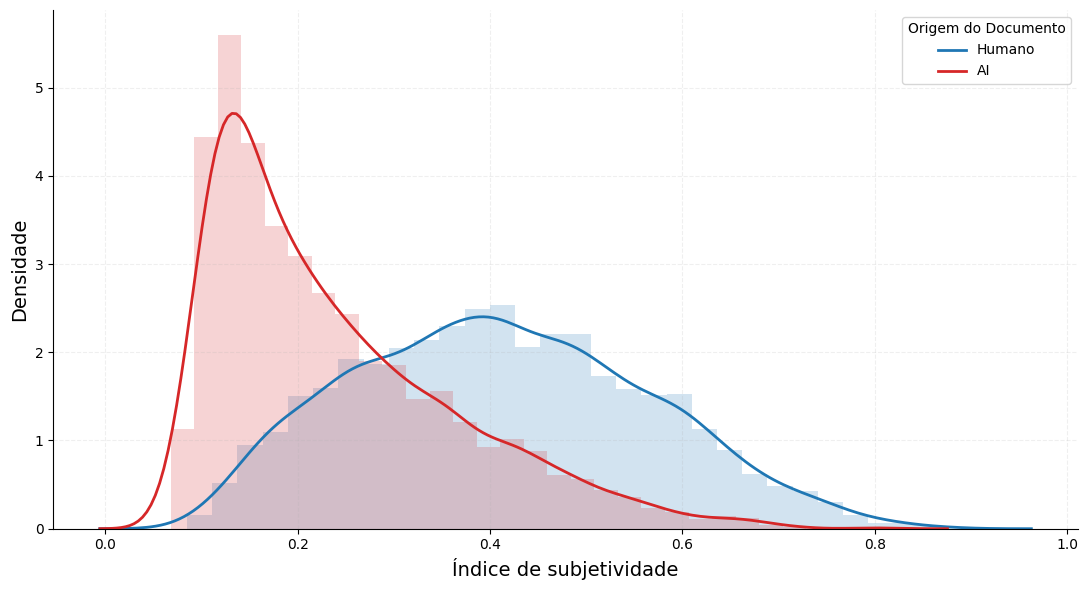

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(11, 6))

# --- Colors (clean & consistent)
human_color = "#1f77b4"   # blue
ai_color    = "#d62728"   # red

# --- HISTOGRAM (bars only, no legend) ---
plt.hist(
    agg.loc[agg["model_doc"] == "human", "mean_subjectivity"],
    bins=30, alpha=0.20, color=human_color, density=True
)

plt.hist(
    agg.loc[agg["model_doc"] == "AI", "mean_subjectivity"],
    bins=30, alpha=0.20, color=ai_color, density=True
)

# --- KDE LINES (with legend) ---
sns.kdeplot(
    agg.loc[agg["model_doc"] == "human", "mean_subjectivity"],
    color=human_color, linewidth=2, label="Humano"
)

sns.kdeplot(
    agg.loc[agg["model_doc"] == "AI", "mean_subjectivity"],
    color=ai_color, linewidth=2, label="AI"
)

# --- Legend only for KDE ---
plt.legend(title="Origem do Documento")

# --- Aesthetic improvements ---
plt.xlabel("Índice de subjetividade", fontsize=14)
plt.ylabel("Densidade", fontsize=14)
plt.grid(alpha=0.20, linestyle="--")
sns.despine()

plt.tight_layout()
plt.savefig("subj_prob_density.png")


In [54]:
import numpy as np

human_mean = agg.loc[agg["model_doc"] == "human", "mean_subjectivity"].mean()
human_std  = agg.loc[agg["model_doc"] == "human", "mean_subjectivity"].std()

ai_mean = agg.loc[agg["model_doc"] == "AI", "mean_subjectivity"].mean()
ai_std  = agg.loc[agg["model_doc"] == "AI", "mean_subjectivity"].std()

print("=== DOCUMENT-LEVEL SUBJECTIVITY ===")
print(f"Human   → mean: {human_mean:.4f}, std: {human_std:.4f}")
print(f"AI      → mean: {ai_mean:.4f}, std: {ai_std:.4f}")


=== DOCUMENT-LEVEL SUBJECTIVITY ===
Human   → mean: 0.4114, std: 0.1530
AI      → mean: 0.2375, std: 0.1263


In [59]:
df.columns.values

array(['sentence_id', 'doc_id', 'text', 'label', 'model', 'source',
       'input_ids', 'attention_mask', '__index_level_0__', 'subjectivity',
       'model_adjusted'], dtype=object)

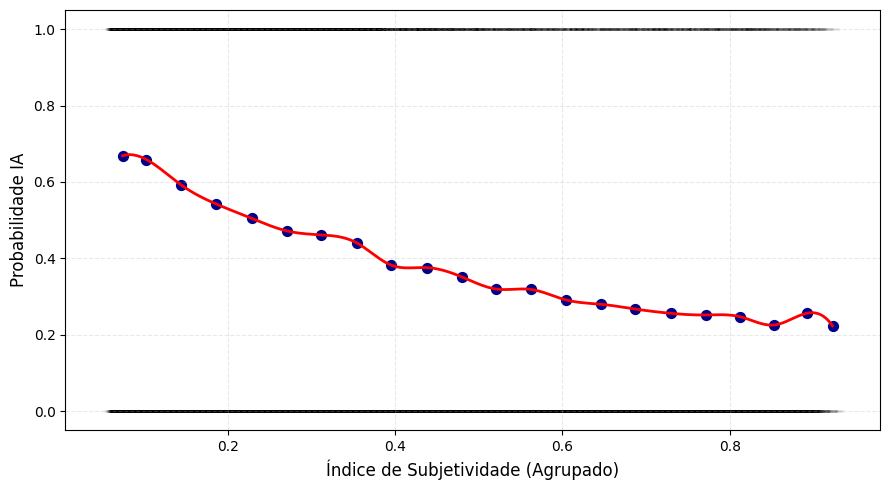

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# --------------------------------------------------------
# Converter seu dataset HuggingFace para pandas
# --------------------------------------------------------
# X = subjetividade
x = df["subjectivity"].values

# Y = rótulo de IA (0 = humano, 1 = IA)
y = df["label"].values.astype(float)

# --------------------------------------------------------
# 1. Scatter plot com transparência (densidade)
# --------------------------------------------------------
plt.figure(figsize=(9,5))
plt.scatter(x, y, alpha=0.01, color="black", s=2)

# --------------------------------------------------------
# 2. Agrupar subjetividade em bins e calcular prob média
# --------------------------------------------------------
bins = np.linspace(0, 1, 25)  # número de bins ajustável
digitized = np.digitize(x, bins)

x_means = []
y_means = []

for i in range(1, len(bins)):
    mask = digitized == i
    if mask.sum() > 5:  # garantir pontos suficientes
        x_means.append(x[mask].mean())
        y_means.append(y[mask].mean())  # isso vira "probabilidade média de IA"

# --------------------------------------------------------
# 3. Suavizar curva de tendência (spline)
# --------------------------------------------------------
x_smooth = np.linspace(min(x_means), max(x_means), 400)
spline = make_interp_spline(x_means, y_means, k=3)
y_smooth = spline(x_smooth)

# --------------------------------------------------------
# 4. Plotar pontos agregados e curva suavizada
# --------------------------------------------------------
plt.scatter(x_means, y_means, color="darkblue", s=50)
plt.plot(x_smooth, y_smooth, color="red", linewidth=2)

# --------------------------------------------------------
# 5. Estética
# --------------------------------------------------------
plt.xlabel("Índice de Subjetividade (Agrupado)", fontsize=12)
plt.ylabel("Probabilidade IA", fontsize=12)
plt.grid(alpha=0.28, linestyle="--")
plt.tight_layout()

plt.show()


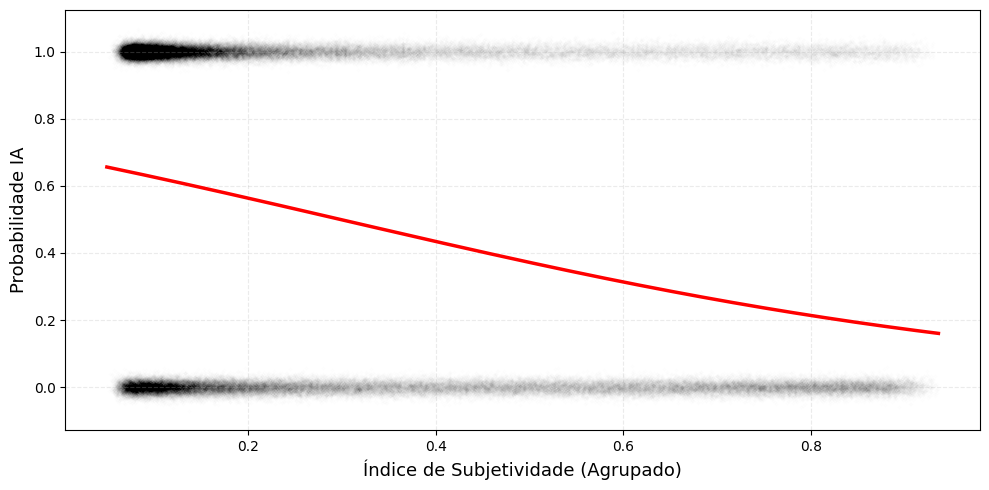

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.special import expit  # sigmoid

# ---- df: seu dataframe convertido a pandas ----
# df['subjectivity']  -> índice de subjetividade
# df['label']         -> 0 = humano, 1 = IA

# Amostragem para deixar o scatter limpo

X = df["subjectivity"].values.reshape(-1, 1)
y = df["label"].values.astype(int)

# Pipeline (padroniza + regressão)
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression())
])

model.fit(X, y)

# Criar eixo suave para curva logística
x_range = np.linspace(df["subjectivity"].min(), df["subjectivity"].max(), 300).reshape(-1, 1)
y_pred_curve = model.predict_proba(x_range)[:, 1]  # probabilidade de ser IA

# ------- Plot -------
plt.figure(figsize=(10, 5))

# Scatter de densidade baixa
plt.scatter(
    X,
    y + np.random.normal(0, 0.015, size=len(y)),  # jitter visual opcional
    alpha=0.005,
    s=4,
    color="black"
)

# Curva logística
plt.plot(
    x_range,
    y_pred_curve,
    color="red",
    linewidth=2.5
)

# Labels
plt.xlabel("Índice de Subjetividade (Agrupado)", fontsize=13)
plt.ylabel("Probabilidade IA", fontsize=13)
plt.grid(alpha=0.25, linestyle="--")

plt.tight_layout()
plt.savefig("scatter_distil.png")
